In [1]:
import os

import numpy as np

import torch
import torchvision
from torchvision.io import read_image
from torchvision.transforms import v2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from piq import BRISQUELoss, TVLoss, brisque, ssim, psnr

import random

import cv2

import matplotlib.pyplot as plt

from utils import loss_history, plot_history

import json

%matplotlib inline

In [2]:
path_hr_img = './data/div2k/DIV2K_train_HR'
path_lr_x2_img = './data/div2k/DIV2K_train_LR_unknown/X2'
images_lr = []
images_hr = []

for filename in os.listdir(path_lr_x2_img):
    img = read_image(os.path.join(path_lr_x2_img, filename))
    transform = torchvision.transforms.Compose([
        v2.ToPureTensor(),
        v2.ToDtype(torch.float)
    ])
    img = transform(img)/255.
    images_lr.append(img)
        
#for filename in os.listdir(path_hr_img):
#    img = read_image(os.path.join(path_hr_img, filename))
#    transform = torchvision.transforms.Compose([
#        v2.ToPureTensor(),
#        v2.ToDtype(torch.float)
#    ])
#    img = transform(img)/255.
#    images_hr.append(img)

In [104]:
i=0
for filename in os.listdir(path_hr_img):
    img = read_image(os.path.join(path_hr_img, filename))
    transform = torchvision.transforms.Compose([
        v2.ToPureTensor(),
        v2.ToDtype(torch.float)
    ])
    img = transform(img)/255.
    images_hr.append(img)
    i+=1
    if i>=6:
        break

In [3]:
images_lr_downscales = []
scale = 2

for image in images_lr:
    resizes = {
        'bilinear': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                 interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
                                                 antialias=True),
        'nearest': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                 interpolation=torchvision.transforms.InterpolationMode.NEAREST,
                                                 antialias=True),
        'nearest_exact': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                 interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT,
                                                 antialias=True),
        'bicubic': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                 interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
                                                 antialias=True),  
    }
    resize_as = random.choice(list(resizes.values()))
    image_downscale = resize_as(image)
    images_lr_downscales.append(image_downscale)

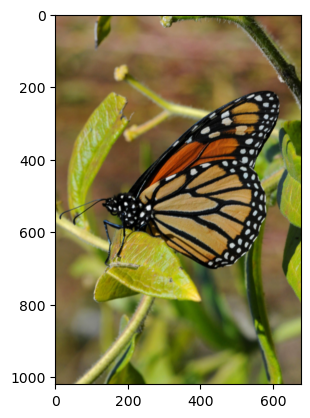

In [4]:
plt.imshow(images_lr[5].permute(1,2,0))

In [5]:
class images_dataset(Dataset):
    def __init__(self, data_source, data_target):
        self.data_source = data_source
        self.data_target = data_target
        
    def __len__(self):
        return len(self.data_source)
    
    def __getitem__(self, index):
        data_source = self.data_source[index]
        data_target = self.data_target[index]
        return data_source, data_target

In [6]:
def collate_fn(batch):
    data_source = torch.LongTensor([item[0] for item in batch])
    data_target = torch.LongTensor([item[1] for item in batch])
    return data_source, data_target

In [7]:
ds_lr_downscaled = images_dataset(images_lr_downscales, images_lr)
ds_lr_downscaled_train = images_dataset(images_lr_downscales[4:5], images_lr[4:5])
ds_lr_downscaled_test = images_dataset(images_lr_downscales[:5], images_lr[:5])
#ds_lr_downscaled_train, ds_lr_downscaled_test = torch.utils.data.random_split(ds_lr_downscaled, [0.8, 0.2])

BATCH_SIZE = 1

dl_lrdown2lr_train = DataLoader(ds_lr_downscaled_train,
                               batch_size=BATCH_SIZE,
                               shuffle=True)
dl_lrdown2lr_test = DataLoader(ds_lr_downscaled_test,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

dl_lrdown2lr = {'train': dl_lrdown2lr_train, 'test': dl_lrdown2lr_test}

In [28]:
class conv_block(nn.Module):
    def __init__(self, *args, **kwargs):
        super(conv_block, self).__init__()
        self.conv1 = nn.Conv2d(*args, **kwargs)
        self.bn = nn.BatchNorm2d(kwargs['out_channels'])
        self.activation = nn.GELU()
        
    def forward(self, x):
        x_input = x
        x = self.conv1(x_input)
        x = self.bn(x)
        x = self.activation(x)
        return x + x_input
        

class lrdown2lr(nn.Module):
    def __init__(self, scale=2, n_blocks=1, channels=64):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.channels = channels
        
        self.upscale = nn.Upsample(scale_factor=2)
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=1, padding='same'),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5,5), stride=1, padding='same')
        )
        self.conv_resc1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding='same'),
            nn.GELU()
        )
        self.conv_inner_blocks = nn.ModuleList(conv_block(in_channels=channels,
                                     out_channels=channels,
                                     kernel_size=3,
                                     padding='same') for n in range(n_blocks))
        
        self.conv_out = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=3, kernel_size=3, padding='same'),
            nn.GELU()
        )

    
    def forward(self, x):
        x = self.upscale(x)
        x = self.conv(x) + self.conv_resc1(x)
        x = self.conv_in(x)
        for conv_inner in self.conv_inner_blocks:
            x = conv_inner(x)
        x = self.conv_out(x)
        x = torch.clamp(x, min=0., max=1.)
       
        return x


In [29]:
class torch_trainer():
    
    def __init__(self, model, criterion, optimizer, epochs, dataloader, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.dataloader = dataloader
        self.device = device
        self.history = loss_history()
        
    
        
    def train(self):

        self.history.clear()
        loss = 0
        val_loss = 0

        for epoch in range(self.epochs):

            epoch_loss = []
            epoch_val_loss = []
            items = len(self.dataloader['train'])

            self.model.train()
            item=1
            for batch in self.dataloader['train']:
                self.optimizer.zero_grad()
                data = batch[0].to(device)
                preds = self.model(data)
                del data
                target = batch[1].to(device)
                loss = self.criterion(preds, target)
                del target
                del preds
                loss.backward()
                epoch_loss.append(loss.numpy(force=True))
                self.optimizer.step()
                print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                item+=1

            items = len(self.dataloader['test'])
            self.model.eval()
            item=1
            with torch.no_grad():
                for batch in self.dataloader['test']:
                    data = batch[0].to(device)
                    preds = self.model(data)
                    del data
                    target = batch[1].to(device)
                    val_loss = self.criterion(preds, target)
                    del target
                    del preds
                    epoch_val_loss.append(val_loss.numpy(force=True))
                    print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                    item+=1

            loss = np.array(epoch_loss).mean()
            val_loss = np.array(epoch_val_loss).mean()

            self.history.loss.append(loss)
            self.history.val_loss.append(val_loss)

            print (f'epoch {epoch+1}/{self.epochs}; train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\n')

        return self.history

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print (device) 

cuda


In [114]:
model = lrdown2lr(channels=256).to(device)
print(model)

lrdown2lr(
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
  (conv): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
  (conv_resc1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (conv_in): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): GELU(approximate='none')
  )
  (conv_inner_blocks): ModuleList(
    (0): conv_block(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): GELU(approximate='none')
    )
  )
  (conv_out): Sequential(
    (0): Conv2d(256, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): GELU(approximate='none')
  )
)


In [115]:
def loss_tv(y_pred, y_true):
    loss = TVLoss()(y_pred)
    loss = 100/loss + 10*nn.SmoothL1Loss()(y_pred, y_true)
    return loss

In [116]:
torch.cuda.empty_cache()
criterion = loss_tv
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
trainer = torch_trainer(model=model,
                       criterion=criterion,
                       optimizer=optimizer,
                       epochs=1000,
                       dataloader=dl_lrdown2lr)
history = trainer.train()

epoch 1/1000; train loss: 2.5305, val_loss: 6.8599 4.4888
epoch 2/1000; train loss: 1.9470, val_loss: 3.9645 4.9550
epoch 3/1000; train loss: 1.6706, val_loss: 2.7283 2.7716
epoch 4/1000; train loss: 1.1666, val_loss: 1.7946 1.4044
epoch 5/1000; train loss: 0.9541, val_loss: 1.4973 1.9322
epoch 6/1000; train loss: 0.9061, val_loss: 1.4191 1.7716
epoch 7/1000; train loss: 0.8353, val_loss: 1.3848 1.7022
epoch 8/1000; train loss: 0.7631, val_loss: 1.3603 1.3259
epoch 9/1000; train loss: 0.7045, val_loss: 1.3365 1.3251
epoch 10/1000; train loss: 0.6824, val_loss: 1.3075 1.4821
epoch 11/1000; train loss: 0.6746, val_loss: 1.2763 1.2641
epoch 12/1000; train loss: 0.6357, val_loss: 1.2485 1.2286
epoch 13/1000; train loss: 0.6372, val_loss: 1.2258 1.3984
epoch 14/1000; train loss: 0.6262, val_loss: 1.2076 1.4609
epoch 15/1000; train loss: 0.6102, val_loss: 1.1929 1.3665
epoch 16/1000; train loss: 0.5914, val_loss: 1.1800 1.4257
epoch 17/1000; train loss: 0.5846, val_loss: 1.1665 0.7609
epoch 

epoch 139/1000; train loss: 0.3828, val_loss: 1.0231 0.8910
epoch 140/1000; train loss: 0.3911, val_loss: 0.9992 1.4114
epoch 141/1000; train loss: 0.3787, val_loss: 0.9251 1.2158
epoch 142/1000; train loss: 0.3760, val_loss: 0.8018 0.8600
epoch 143/1000; train loss: 0.3795, val_loss: 0.7674 0.8674
epoch 144/1000; train loss: 0.3692, val_loss: 0.7568 0.8520
epoch 145/1000; train loss: 0.3709, val_loss: 0.7436 0.6079
epoch 146/1000; train loss: 0.3698, val_loss: 0.7781 0.8586
epoch 147/1000; train loss: 0.3759, val_loss: 0.8149 0.6837
epoch 148/1000; train loss: 0.3722, val_loss: 0.8057 0.6669
epoch 149/1000; train loss: 0.3717, val_loss: 0.7815 0.8972
epoch 150/1000; train loss: 0.3894, val_loss: 0.7017 0.4736
epoch 151/1000; train loss: 0.3568, val_loss: 0.7182 0.7961
epoch 152/1000; train loss: 0.3882, val_loss: 0.8261 0.6386
epoch 153/1000; train loss: 0.3771, val_loss: 0.8023 0.6497
epoch 154/1000; train loss: 0.4221, val_loss: 0.7542 0.8418
epoch 155/1000; train loss: 0.3777, val_

epoch 275/1000; train loss: 0.3485, val_loss: 0.5716 0.3960
epoch 276/1000; train loss: 0.3478, val_loss: 0.5901 0.7661
epoch 277/1000; train loss: 0.3392, val_loss: 0.6187 0.7680
epoch 278/1000; train loss: 0.3357, val_loss: 0.6801 0.8871
epoch 279/1000; train loss: 0.3534, val_loss: 0.5686 0.7178
epoch 280/1000; train loss: 0.3385, val_loss: 0.5855 0.6941
epoch 281/1000; train loss: 0.3549, val_loss: 0.5693 0.7112
epoch 282/1000; train loss: 0.3451, val_loss: 0.5973 0.7447
epoch 283/1000; train loss: 0.3527, val_loss: 0.5980 0.3911
epoch 284/1000; train loss: 0.3475, val_loss: 0.5873 0.3392
epoch 285/1000; train loss: 0.3422, val_loss: 0.5955 0.7343
epoch 286/1000; train loss: 0.3434, val_loss: 0.5942 0.7478
epoch 287/1000; train loss: 0.3413, val_loss: 0.6070 0.4101
epoch 288/1000; train loss: 0.3409, val_loss: 0.5917 0.7624
epoch 289/1000; train loss: 0.3386, val_loss: 0.5983 0.7386
epoch 290/1000; train loss: 0.3377, val_loss: 0.6005 0.7149
epoch 291/1000; train loss: 0.3346, val_

epoch 411/1000; train loss: 0.2899, val_loss: 0.4645 0.3041
epoch 412/1000; train loss: 0.2890, val_loss: 0.4868 0.6359
epoch 413/1000; train loss: 0.2834, val_loss: 0.4979 0.3201
epoch 414/1000; train loss: 0.2816, val_loss: 0.4979 0.6476
epoch 415/1000; train loss: 0.2778, val_loss: 0.5388 0.7202
epoch 416/1000; train loss: 0.2837, val_loss: 0.5174 0.3741
epoch 417/1000; train loss: 0.2777, val_loss: 0.4900 0.3118
epoch 418/1000; train loss: 0.2778, val_loss: 0.4811 0.6261
epoch 419/1000; train loss: 0.2779, val_loss: 0.4663 0.6089
epoch 420/1000; train loss: 0.2767, val_loss: 0.4614 0.3025
epoch 421/1000; train loss: 0.2783, val_loss: 0.4647 0.2992
epoch 422/1000; train loss: 0.2734, val_loss: 0.4628 0.5456
epoch 423/1000; train loss: 0.2719, val_loss: 0.4623 0.5479
epoch 424/1000; train loss: 0.2755, val_loss: 0.4656 0.3591
epoch 425/1000; train loss: 0.2749, val_loss: 0.4586 0.5373
epoch 426/1000; train loss: 0.2708, val_loss: 0.4605 0.4930
epoch 427/1000; train loss: 0.2736, val_

epoch 547/1000; train loss: 0.2630, val_loss: 0.4436 0.5935
epoch 548/1000; train loss: 0.2629, val_loss: 0.4475 0.6023
epoch 549/1000; train loss: 0.2626, val_loss: 0.4491 0.2925
epoch 550/1000; train loss: 0.2629, val_loss: 0.4489 0.2965
epoch 551/1000; train loss: 0.2628, val_loss: 0.4498 0.2933
epoch 552/1000; train loss: 0.2629, val_loss: 0.4505 0.5137
epoch 553/1000; train loss: 0.2631, val_loss: 0.4514 0.6012
epoch 554/1000; train loss: 0.2630, val_loss: 0.4550 0.5193
epoch 555/1000; train loss: 0.2633, val_loss: 0.4524 0.2846
epoch 556/1000; train loss: 0.2635, val_loss: 0.4545 0.6168
epoch 557/1000; train loss: 0.2638, val_loss: 0.4496 0.3427
epoch 558/1000; train loss: 0.2641, val_loss: 0.4514 0.6113
epoch 559/1000; train loss: 0.2644, val_loss: 0.4502 0.3405
epoch 560/1000; train loss: 0.2648, val_loss: 0.4500 0.5186
epoch 561/1000; train loss: 0.2653, val_loss: 0.4484 0.2740
epoch 562/1000; train loss: 0.2654, val_loss: 0.4443 0.3447
epoch 563/1000; train loss: 0.2655, val_

epoch 683/1000; train loss: 0.2614, val_loss: 0.4175 0.4994
epoch 684/1000; train loss: 0.2615, val_loss: 0.4218 0.5617
epoch 685/1000; train loss: 0.2617, val_loss: 0.4173 0.5567
epoch 686/1000; train loss: 0.2620, val_loss: 0.4242 0.3222
epoch 687/1000; train loss: 0.2625, val_loss: 0.4174 0.3210
epoch 688/1000; train loss: 0.2633, val_loss: 0.4272 0.5700
epoch 689/1000; train loss: 0.2644, val_loss: 0.4184 0.5620
epoch 690/1000; train loss: 0.2663, val_loss: 0.4341 0.3284
epoch 691/1000; train loss: 0.2687, val_loss: 0.4211 0.5690
epoch 692/1000; train loss: 0.2713, val_loss: 0.4405 0.5898
epoch 693/1000; train loss: 0.2739, val_loss: 0.4210 0.3281
epoch 694/1000; train loss: 0.2717, val_loss: 0.4341 0.3280
epoch 695/1000; train loss: 0.2694, val_loss: 0.4194 0.2688
epoch 696/1000; train loss: 0.2667, val_loss: 0.4273 0.4693
epoch 697/1000; train loss: 0.2645, val_loss: 0.4171 0.2643
epoch 698/1000; train loss: 0.2632, val_loss: 0.4242 0.4641
epoch 699/1000; train loss: 0.2624, val_

epoch 819/1000; train loss: 0.2605, val_loss: 0.4172 0.3173
epoch 820/1000; train loss: 0.2605, val_loss: 0.4168 0.2610
epoch 821/1000; train loss: 0.2605, val_loss: 0.4131 0.4911
epoch 822/1000; train loss: 0.2604, val_loss: 0.4153 0.4530
epoch 823/1000; train loss: 0.2606, val_loss: 0.4123 0.5490
epoch 824/1000; train loss: 0.2606, val_loss: 0.4171 0.4558
epoch 825/1000; train loss: 0.2607, val_loss: 0.4157 0.5547
epoch 826/1000; train loss: 0.2609, val_loss: 0.4202 0.5600
epoch 827/1000; train loss: 0.2611, val_loss: 0.4136 0.4458
epoch 828/1000; train loss: 0.2613, val_loss: 0.4198 0.4990
epoch 829/1000; train loss: 0.2616, val_loss: 0.4137 0.5524
epoch 830/1000; train loss: 0.2620, val_loss: 0.4242 0.5643
epoch 831/1000; train loss: 0.2625, val_loss: 0.4149 0.3183
epoch 832/1000; train loss: 0.2632, val_loss: 0.4271 0.5687
epoch 833/1000; train loss: 0.2641, val_loss: 0.4162 0.4429
epoch 834/1000; train loss: 0.2654, val_loss: 0.4337 0.4838
epoch 835/1000; train loss: 0.2668, val_

epoch 955/1000; train loss: 0.2613, val_loss: 0.4066 0.3136
epoch 956/1000; train loss: 0.2618, val_loss: 0.4259 0.2666
epoch 957/1000; train loss: 0.2635, val_loss: 0.4031 0.3119
epoch 958/1000; train loss: 0.2642, val_loss: 0.4176 0.5556
epoch 959/1000; train loss: 0.2653, val_loss: 0.3997 0.2676
epoch 960/1000; train loss: 0.2660, val_loss: 0.4238 0.5676
epoch 961/1000; train loss: 0.2668, val_loss: 0.4027 0.2703
epoch 962/1000; train loss: 0.2677, val_loss: 0.4269 0.4929
epoch 963/1000; train loss: 0.2687, val_loss: 0.4116 0.2727
epoch 964/1000; train loss: 0.2675, val_loss: 0.4238 0.3219
epoch 965/1000; train loss: 0.2659, val_loss: 0.4045 0.5409
epoch 966/1000; train loss: 0.2640, val_loss: 0.4183 0.4879
epoch 967/1000; train loss: 0.2626, val_loss: 0.4062 0.3131
epoch 968/1000; train loss: 0.2617, val_loss: 0.4164 0.4867
epoch 969/1000; train loss: 0.2610, val_loss: 0.4102 0.5468
epoch 970/1000; train loss: 0.2606, val_loss: 0.4177 0.4904
epoch 971/1000; train loss: 0.2604, val_

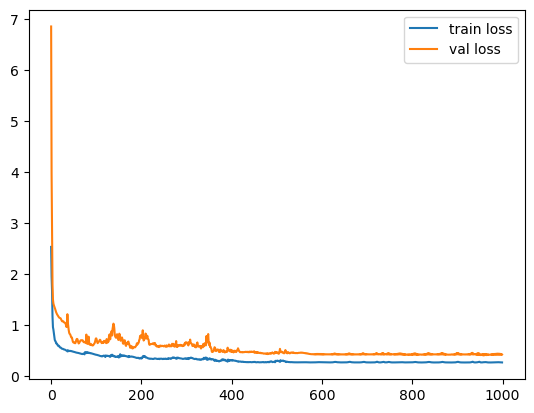

In [117]:
plot_history(history)

In [61]:
def plot_history(history):
    plt.plot(history.loss, label='train loss')
    plt.plot(history.val_loss, label='val loss')
    plt.legend()
    plt.show()

In [27]:
del images_lr_downscales

tensor(0.9648, device='cuda:0')


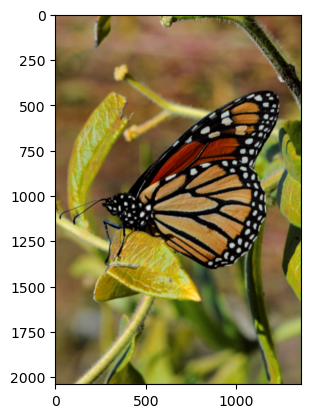

In [118]:
#model = model.to('cpu')
#test = images_lr_downscales[0]
test = images_lr[5].to(device)
test = test[None, :]
model.eval()
with torch.no_grad():
    preds = model(test)
img = preds[0].permute(1,2,0).to('cpu')
torchvision.utils.save_image(preds[0], 'out_from_downscaled_div2k.png')
plt.imshow(img)

ref = images_hr[5].to(device)
ref = ref[None, :]
ssim_after = ssim(preds, ref, data_range=1)
print(ssim_after)

In [112]:
ref = images_hr[5].to(device)
ref = ref[None, :]
ssim_after = ssim(preds, ref, data_range=1)
print(ssim_after)

tensor(0.9677, device='cuda:0')


In [29]:
preds[0]

tensor([[[0.3988, 0.4764, 0.4871,  ..., 0.2906, 0.2826, 0.2443],
         [0.4762, 0.5701, 0.6083,  ..., 0.3974, 0.3654, 0.3017],
         [0.5138, 0.5977, 0.6525,  ..., 0.4454, 0.4080, 0.3076],
         ...,
         [0.3915, 0.4510, 0.4814,  ..., 0.5718, 0.5544, 0.4468],
         [0.3794, 0.4250, 0.4504,  ..., 0.5538, 0.5116, 0.3806],
         [0.3281, 0.3726, 0.3903,  ..., 0.4510, 0.3786, 0.3043]],

        [[0.3825, 0.4075, 0.4439,  ..., 0.2700, 0.2564, 0.3025],
         [0.4281, 0.4572, 0.4878,  ..., 0.3000, 0.2896, 0.2574],
         [0.4457, 0.4815, 0.5159,  ..., 0.3231, 0.3182, 0.2875],
         ...,
         [0.3442, 0.3874, 0.4122,  ..., 0.5190, 0.5033, 0.4227],
         [0.3376, 0.3965, 0.4040,  ..., 0.5052, 0.4792, 0.3780],
         [0.2725, 0.3815, 0.3893,  ..., 0.4535, 0.4007, 0.3075]],

        [[0.3418, 0.3633, 0.4022,  ..., 0.1909, 0.2118, 0.2030],
         [0.3665, 0.3584, 0.4041,  ..., 0.1411, 0.1710, 0.1944],
         [0.3835, 0.3613, 0.4096,  ..., 0.1221, 0.1497, 0.

In [24]:
torch.cuda.empty_cache()

In [24]:
test.device

device(type='cpu')

In [23]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [25]:
torchvision.utils.save_image(images_lr_downscales[0]/255., 'test2.png')

# deblur

In [16]:
class nn_deblur(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(7,7), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
        )
        self.conv_resc1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        #self.conv2 = nn.Sequential(
        #    nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
        #    nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding='same'),
        #    nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(7,7), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
        #)
        #self.conv_resc2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        self.act = nn.GELU()
        
    def forward(self, x):
        x = x.type(torch.cuda.FloatTensor)
        x = self.conv1(x) + self.conv_resc1(x)
        #x = self.conv2(x) + self.conv_resc2(x)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=255)
        return x

In [45]:
ds_deblur_train = images_dataset(images_lr[:100], images_lr[:100])
ds_deblur_test = images_dataset(images_lr_test[:100], images_lr_test[:100])

BATCH_SIZE = 1

dl_deblur_train = DataLoader(ds_deblur_train,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
dl_deblur_test = DataLoader(ds_deblur_test,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur = {'train': dl_deblur_train, 'test': dl_deblur_test}

ds_deblur_withscale = images_dataset(images_lr_downscales[:10], images_lr[:10])
dl_deblur_withscale = DataLoader(ds_deblur_withscale,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur_withscale = {'train': dl_deblur, 'test': dl_deblur_test}

In [46]:
model_deblur = nn_deblur(3).to(device)
print(model_deblur)

def loss_brisque(y_pred, y_true):
    loss = BRISQUELoss(data_range=255)(y_pred)
    loss = 100/loss + 0.01*nn.L1Loss()(y_pred, y_true)

    return loss

def loss_tv(y_pred, y_true):
    loss = TVLoss()(y_pred)
    loss = 10000/loss + 0.01*nn.L1Loss()(y_pred, y_true)
    return loss

def loss_agm(y_pred, y_true):
    y = y_pred[0]
    gy, gx, gc = torch.gradient(y)
    gnorm = torch.sqrt(gx**2 + gy**2)
    return torch.mean(gnorm) #+ nn.MSELoss()(y_pred, y_true)

def loss_fft(y_pred, y_true):
    return 1/(tensor2freq(y_pred)+1e-10) #+ 0.01*nn.L1Loss()(y_pred, y_true)

def loss_tv_psnr(y_pred, y_true):
    loss_tv = TVLoss()(y_pred)
    loss_tv = 10000/loss_tv
    loss_psnr = psnr(y_pred, y_true, data_range=255, convert_to_greyscale=True)
    loss_psnr = 100 - loss_psnr
    return loss_tv + 0.01*loss_psnr + 0.01*nn.L1Loss()(y_pred, y_true)

def loss_tv_ssim(y_pred, y_true):
    loss_tv = TVLoss()(y_pred)
    loss_tv = 10000/loss_tv
    loss_ssim = ssim(y_pred, y_true, data_range=255)
    loss_ssim = 1 - loss_psnr
    return loss_tv + 0.1*loss_ssim #+ 0.01*nn.L1Loss()(y_pred, y_true)

criterion_deblur = loss_tv
optimizer = torch.optim.AdamW(model_deblur.parameters(), lr=1e-3)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
trainer = torch_trainer(model=model_deblur,
                       criterion=criterion_deblur,
                       optimizer=optimizer,
                       epochs=2000,
                       dataloader=dl_deblur)
history = trainer.train()


nn_deblur(
  (conv1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
  (conv_resc1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (act): GELU(approximate='none')
)
epoch 1/2000; train loss: 1.0029, val_loss: 0.8742s: 0.552100
epoch 2/2000; train loss: 0.6986, val_loss: 0.7482s: 0.511142
epoch 3/2000; train loss: 0.6267, val_loss: 0.7112s: 0.505082
epoch 4/2000; train loss: 0.6000, val_loss: 0.6789s: 0.491712
epoch 5/2000; train loss: 0.5799, val_loss: 0.6497s: 0.475389
epoch 6/2000; train loss: 0.5614, val_loss: 0.6191s: 0.456797
epoch 7/2000; train loss: 0.5440, val_loss: 0.5961s: 0.440991
epoch 8/2000; train loss: 0.5262, val_loss: 0.5727s: 0.423961
epoch 9/2000; train loss: 0.5087, val_loss: 0.5472s: 0.406827
epoch 10/2000; train loss: 0.4955, val_loss: 0.5288s: 0.395472
epoch 11/2000; train loss: 0.4835, val_loss: 0.5084s: 0.384788
epoch 12/2000; train l

epoch 254/2000; train loss: 0.3253, val_loss: 0.3424s: 0.245333
epoch 255/2000; train loss: 0.3250, val_loss: 0.3454s: 0.247224
epoch 256/2000; train loss: 0.3274, val_loss: 0.3441s: 0.246354
epoch 257/2000; train loss: 0.3256, val_loss: 0.3446s: 0.245641
epoch 258/2000; train loss: 0.3255, val_loss: 0.3429s: 0.244546
epoch 259/2000; train loss: 0.3241, val_loss: 0.3459s: 0.246929
epoch 260/2000; train loss: 0.3252, val_loss: 0.3435s: 0.245059
epoch 261/2000; train loss: 0.3231, val_loss: 0.3422s: 0.243835
epoch 262/2000; train loss: 0.3243, val_loss: 0.3411s: 0.242822
epoch 263/2000; train loss: 0.3226, val_loss: 0.3417s: 0.243111
epoch 264/2000; train loss: 0.3236, val_loss: 0.3432s: 0.244617
epoch 265/2000; train loss: 0.3230, val_loss: 0.3419s: 0.243132
epoch 266/2000; train loss: 0.3236, val_loss: 0.3416s: 0.242919
epoch 267/2000; train loss: 0.3231, val_loss: 0.3395s: 0.241616
epoch 268/2000; train loss: 0.3231, val_loss: 0.3404s: 0.241895
epoch 269/2000; train loss: 0.3229, val_

KeyboardInterrupt: 

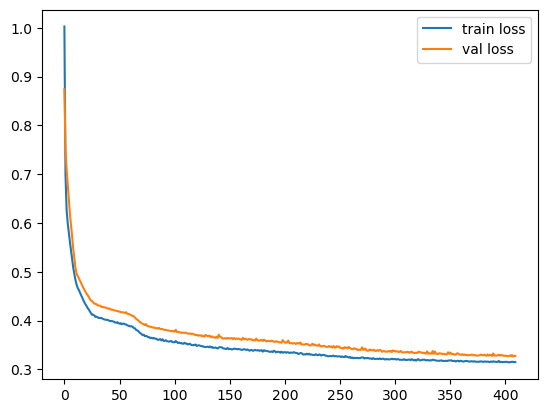

In [47]:
plot_history(history)

tensor(0.9195) tensor(0.9263)


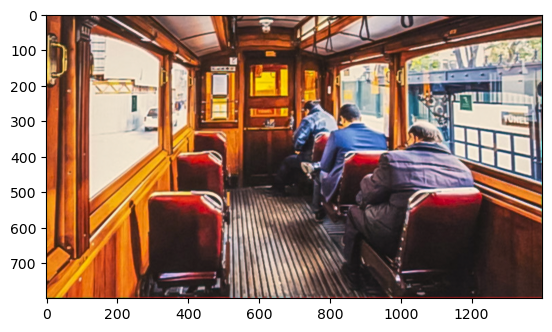

In [48]:
#test = images_lr[0]
test = read_image('out_before.png')
test = test[None, :]
model_deblur.eval()
with torch.no_grad():
    preds = model_deblur(test).type(torch.LongTensor)
img = preds[0].permute(1,2,0).detach()
to_save = (preds[0])/255.
torchvision.utils.save_image(to_save, 'out.png')
plt.imshow(img)

ref = images_hr[0]
ref = ref[None, :]
ssim_after = ssim(preds, ref, data_range=255)
ssim_before = ssim(test, ref, data_range=255)
print(ssim_after, ssim_before)

In [439]:
torch.save(model_deblur, 'ssim09282_1000epochs')
torch.save({
            'epoch': 1000,
            'model_state_dict': model_deblur.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion_deblur
            }, 'torch_ssim09282_1000epochs')

In [422]:
images_lr[0]

tensor([[[0.4980, 0.5686, 0.6078,  ..., 0.1961, 0.2039, 0.2078],
         [0.4941, 0.5529, 0.5804,  ..., 0.2157, 0.2196, 0.2235],
         [0.5059, 0.5529, 0.5725,  ..., 0.2706, 0.2824, 0.2941],
         ...,
         [0.9490, 0.9608, 0.9412,  ..., 0.2471, 0.2431, 0.2353],
         [0.9608, 0.9490, 0.9255,  ..., 0.2431, 0.2431, 0.2353],
         [0.9412, 0.9137, 0.9020,  ..., 0.2431, 0.2431, 0.2431]],

        [[0.2549, 0.2941, 0.3020,  ..., 0.1529, 0.1529, 0.1529],
         [0.2353, 0.2706, 0.2784,  ..., 0.1529, 0.1490, 0.1412],
         [0.2235, 0.2510, 0.2627,  ..., 0.1686, 0.1686, 0.1725],
         ...,
         [0.5490, 0.5686, 0.5490,  ..., 0.1608, 0.1569, 0.1490],
         [0.5608, 0.5529, 0.5333,  ..., 0.1608, 0.1569, 0.1529],
         [0.5333, 0.5137, 0.5020,  ..., 0.1608, 0.1608, 0.1647]],

        [[0.1451, 0.1725, 0.1843,  ..., 0.1412, 0.1451, 0.1529],
         [0.1569, 0.1882, 0.1922,  ..., 0.1294, 0.1333, 0.1333],
         [0.1647, 0.1922, 0.1961,  ..., 0.1373, 0.1451, 0.

In [76]:
images_lr[0][0].numpy().shape

(400, 700)

In [79]:
lr = images_lr_downscales[0][0].numpy()
hr = images_hr[0][0].numpy()

gy, gx = np.gradient(lr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

gy, gx = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

21.01626905868889
10.95381203369981


In [88]:
lr = images_lr_downscales[0].type(torch.FloatTensor)
hr = images_hr[0].type(torch.FloatTensor)

gy, gx, gc = torch.gradient(lr)
gnorm = torch.sqrt(gx**2 + gy**2 + gc**2)
print(torch.mean(gnorm))

gy, gx, gc = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2 + gc**2)
print(np.average(gnorm))

tensor(40.4811)
34.710903


In [180]:
trainer.loss.grad

In [268]:
def dft_amp(img):
    fft_im = torch.fft.rfft( img, signal_ndim=2, onesided=False )
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    return torch.sqrt(fft_amp)

dft_amp(images_lr[0])

TypeError: fft_rfft() got an unexpected keyword argument 'signal_ndim'

In [276]:
torch.fft.rfft(images_hr[0]).shape

torch.Size([3, 800, 701])

In [292]:
def tensor2freq(x):
    # crop image patches
    patch_factor = 1
    _, _, h, w = x.shape
    assert h % patch_factor == 0 and w % patch_factor == 0, (
        'Patch factor should be divisible by image height and width')
    patch_list = []
    patch_h = h // patch_factor
    patch_w = w // patch_factor
    for i in range(patch_factor):
        for j in range(patch_factor):
            patch_list.append(x[:, :, i * patch_h:(i + 1) * patch_h, j * patch_w:(j + 1) * patch_w])

        # stack to patch tensor
    y = torch.stack(patch_list, 1)

    # perform 2D DFT (real-to-complex, orthonormalization)
    freq = torch.fft.fft2(y, norm='ortho')
    freq = torch.stack([freq.real, freq.imag], -1)
    
    return freq.mean()


In [293]:
test = images_lr[0]
test = test[None, :]
tensor2freq(test)

tensor(0.0721)

In [4]:
def getSharpness(images):
    sharpness_vals = []
    derivative_imgs = []
    for img in images:
        derivative = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        derivative_imgs.append(derivative)
        sharpness_vals.append(cv2.norm(derivative))
    return derivative_imgs, sharpness_vals

In [19]:
images_np = np.array(images_lr[0])
a, b = getSharpness(images_np)

In [42]:
b

[924742.4838478008, 804595.2767317243, 728193.959805353]

In [36]:
a

[array([[   0.,  908.,  760., ...,  150.,  136.,    0.],
        [   0.,  842.,  656., ...,  227.,  185.,    0.],
        [   0.,  751.,  504., ...,  409.,  316.,    0.],
        ...,
        [   0., -190., -472., ...,  -66.,  -76.,    0.],
        [   0., -343., -505., ...,  -78.,  -74.,    0.],
        [   0., -388., -478., ...,  -80.,  -66.,    0.]]),
 array([[   0.,  346.,   94., ...,  -16.,  -46.,    0.],
        [   0.,  362.,  129., ...,   20.,   -4.,    0.],
        [   0.,  410.,  196., ...,  150.,  141.,    0.],
        ...,
        [   0., -124., -482., ...,  -58.,  -70.,    0.],
        [   0., -283., -510., ...,  -72.,  -65.,    0.],
        [   0., -330., -486., ...,  -74.,  -54.,    0.]]),
 array([[   0.,  276.,   24., ...,   74.,  100.,    0.],
        [   0.,  278.,   15., ...,  134.,  152.,    0.],
        [   0.,  309.,   18., ...,  307.,  312.,    0.],
        ...,
        [   0., -101., -523., ...,  -69.,  -76.,    0.],
        [   0., -308., -626., ...,  -87.,  -9

In [18]:
torch_sobel = Sobel()

In [38]:
images_tensor = torch.FloatTensor(np.array(images_lr[:1]))
im_gr = torchvision.transforms.Grayscale()(images_tensor)
print(im_gr.shape)
derivs = torch_sobel(im_gr)
derivs

torch.Size([1, 1, 400, 700])


tensor([[[[124.3786,  65.1107,  70.5449,  ...,  55.6721,  64.9517,  68.5075],
          [110.8581,  22.6103,  26.8387,  ..., 168.0509, 195.4942, 243.8969],
          [119.5695,  33.0675,  40.2347,  ..., 320.4005, 336.0049, 361.7405],
          ...,
          [ 73.6868,  53.7021, 105.2892,  ...,   0.8454,   4.0844,  14.1444],
          [  1.1179,  93.7471, 108.4399,  ...,   2.1554,   7.5163,  18.8298],
          [ 91.5316, 105.1587,  86.2123,  ...,   9.7318,  11.0912,  16.1775]]]])

In [43]:
torch.linalg.norm(derivs)

tensor(165562.7188)

In [70]:
loss_sobel(images_tensor, None)

tensor(165562.7188, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


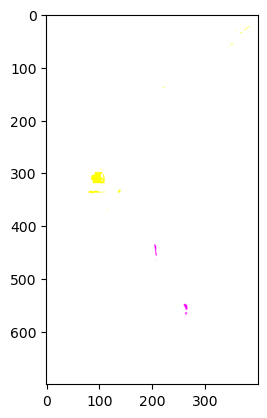

In [163]:
images_tensor = torch.FloatTensor(np.array(images_lr[0]))
blur = torchvision.transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.))(images_tensor)
plt.imshow(blur.T)
torchvision.utils.save_image(blur, 'test1_blur.png')

In [ ]:
class Sobel(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0, bias=False)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = nn.Parameter(G, requires_grad=True)

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
        return x
    
def loss_sobel(y_pred, y_true):
    torch_sobel = Sobel()
    grayscale = torchvision.transforms.Grayscale()(y_pred)
    out = torch.linalg.norm(torch_sobel(grayscale))
    print(out)
    return 1/out    

In [262]:
ignite.============

[tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126, 141, 148,  ...,  55,  56,  57],
          [129, 141, 146,  ...,  69,  72,  75],
          ...,
          [242, 245, 240,  ...,  63,  62,  60],
          [245, 242, 236,  ...,  62,  62,  60],
          [240, 233, 230,  ...,  62,  62,  62]],

         [[ 65,  75,  77,  ...,  39,  39,  39],
          [ 60,  69,  71,  ...,  39,  38,  36],
          [ 57,  64,  67,  ...,  43,  43,  44],
          ...,
          [140, 145, 140,  ...,  41,  40,  38],
          [143, 141, 136,  ...,  41,  40,  39],
          [136, 131, 128,  ...,  41,  41,  42]],

         [[ 37,  44,  47,  ...,  36,  37,  39],
          [ 40,  48,  49,  ...,  33,  34,  34],
          [ 42,  49,  50,  ...,  35,  37,  40],
          ...,
          [ 32,  40,  36,  ...,  36,  34,  34],
          [ 39,  38,  33,  ...,  36,  35,  33],
          [ 39,  31,  27,  ...,  37,  36,  36]]]], dtype=torch.uint8), tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126,